In [1]:
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(666)

# 使用make_classification 制造数据
# 模仿论文所使用的数据集 2%:98% 为了可视化方便使用2D数据
X, y = make_classification(n_samples=500,
                           n_features=9,
                           n_redundant=3,
                           weights=(0.1, 0.9),
                           n_clusters_per_class=2,
                           random_state=666)


In [2]:
X.shape, y.shape

((500, 9), (500,))

In [3]:
def view_y(y):
    print(f"class 0: {len(np.where(y==0)[0])}\nclass 1: {len(np.where(y==1)[0])}")
view_y(y)

class 0: 50
class 1: 450


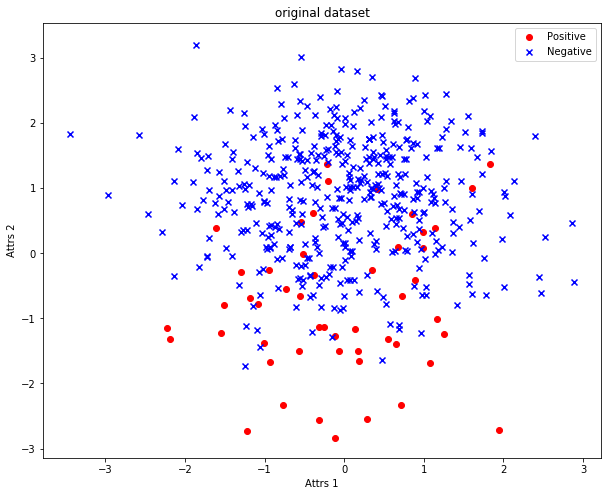

In [4]:
plt.figure(figsize=(10, 8))
def plot2class(pos, neg, title=""):
    plt.scatter(pos[:, 0], pos[:, 1], marker='o',
               c="#ff0000", label="Positive")

    plt.scatter(neg[:, 0], neg[:, 1], marker='x',
               c="#0000ff", label="Negative")
    plt.legend()
    plt.title(title)
    plt.xlabel("Attrs 1")
    plt.ylabel("Attrs 2")
plot2class(X[y==0], X[y==1], "original dataset")
plt.show()

原版SMOTE算法

```
Algorithm SMOTE(T, N, k)
Input: Number of minority class samples T; Amount of SMOTE N%; Number of nearest
neighbors k
Output: (N/100) * T synthetic minority class samples
1. (∗ If N is less than 100%, randomize the minority class samples as only a random
percent of them will be SMOTEd. ∗)
2. if N < 100
3. then Randomize the T minority class samples
4. T = (N/100) ∗ T
5. N = 100
6. endif
7. N = (int)(N/100) (∗ The amount of SMOTE is assumed to be in integral multiples of
100. ∗)
8. k = Number of nearest neighbors
9. numattrs = Number of attributes
10. Sample[ ][ ]: array for original minority class samples
11. newindex: keeps a count of number of synthetic samples generated, initialized to 0
12. Synthetic[ ][ ]: array for synthetic samples
(∗ Compute k nearest neighbors for each minority class sample only. ∗)
13. for i ← 1 to T
14. Compute k nearest neighbors for i, and save the indices in the nnarray
15. Populate(N, i, nnarray)
16. endfor

Populate(N, i, nnarray) (∗ Function to generate the synthetic samples. ∗)
17. while N != 0
18. Choose a random number between 1 and k, call it nn. This step chooses one of
the k nearest neighbors of i.
19. for attr ← 1 to numattrs
20. Compute: dif = Sample[nnarray[nn]][attr] Sample[i][attr]
21. Compute: gap = random number between 0 and 1
22. Synthetic[newindex][attr] = Sample[i][attr] + gap ∗ dif
23. endfor
24. newindex++
25. N = N-1
26. endwhile
27. return (∗ End of Populate. ∗)
End of Pseudo-Code.
```

In [5]:
def NaiveSMOTE(X, N=100, K=5):
    """
    {X}: minority class samples;
    {N}: Amount of SMOTE; default 100;
    {K} Number of nearest; default 5;
    """
    # {T}: Number of minority class samples; 
    T = X.shape[0]
    if N < 100:
        T = (N/100) * T
        N = 100
    N = (int)(N/100)
    
    numattrs = X.shape[1]
    samples = X[:T]
    neigh = NearestNeighbors(n_neighbors=K)
    neigh.fit(samples)
    Synthetic = np.zeros((T*N, numattrs))
    newindex = 0
    
    def Populate(N, i, nns, newindex):
        """
        Function to generate the synthetic samples.
        """
        for n in range(N):
            nn = np.random.randint(0, K)
            for attr in range(numattrs):
                dif = samples[nns[nn], attr] - samples[i, attr]
                gap = np.random.random()
                Synthetic[newindex, attr] = samples[i, attr] + gap*dif
            newindex += 1
        return newindex
    
    for i in range(T):
        nns = neigh.kneighbors([samples[i]], K, return_distance=False)
        newindex = Populate(N, i, nns[0], newindex)
    return Synthetic
    

In [6]:
X_over_sampling = NaiveSMOTE(X[y==0], N=800)

In [7]:
X_over_sampling.shape

(400, 9)

In [8]:
new_X = np.r_[X, X_over_sampling]
new_y = np.r_[y, np.zeros((X_over_sampling.shape[0]))]
new_X.shape, new_y.shape

((900, 9), (900,))

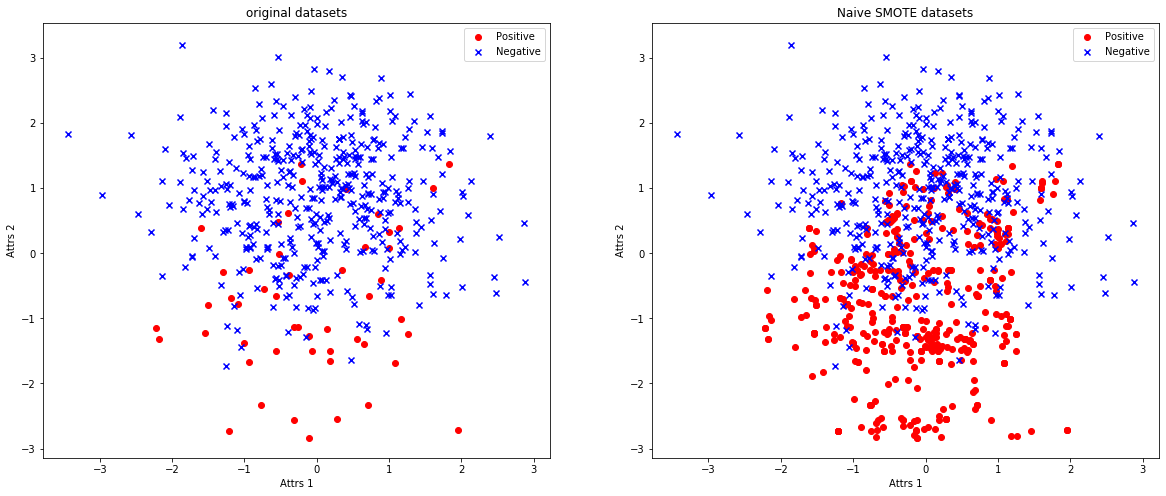

In [9]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot2class(X[y==0], X[y==1], 
           title="original datasets")

plt.subplot(1, 2, 2)
plot2class(new_X[new_y==0], new_X[new_y==1], 
           title="Naive SMOTE datasets")
plt.show()

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=666)
X_res, y_res = sm.fit_resample(X, y)

Using TensorFlow backend.


In [11]:
X_res.shape, y_res.shape

((900, 9), (900,))

In [12]:
print("thrid SMOTE")
view_y(y_res)
print("Naive SMOTE")
view_y(new_y)

thrid SMOTE
class 0: 450
class 1: 450
Naive SMOTE
class 0: 450
class 1: 450


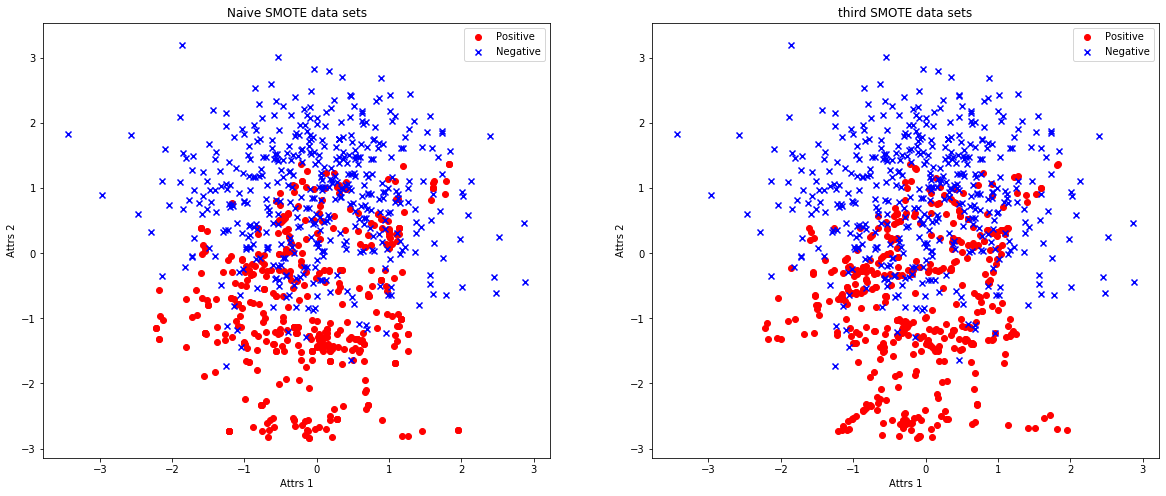

In [13]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot2class(new_X[new_y==0], new_X[new_y==1], 
           title="Naive SMOTE data sets")

plt.subplot(1, 2, 2)
plot2class(X_res[y_res==0], X_res[y_res==1], 
           title="third SMOTE data sets")
plt.show()

In [14]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, plot_roc_curve
# 使用决策树, Gaussian Navie Bayes验证元数据与SMOTE采样后的数据的表现
# 测试元数据
stkf = StratifiedKFold(n_splits=5, random_state=666, shuffle=True)
fold = 1

ori_X, ori_X_test, \
ori_y, ori_y_test = train_test_split(X, y, random_state=666)

best_tree_est = None
best_tree_f1 = -np.Inf
best_gnb_est = None
best_gnb_f1 = -np.Inf

for train_index, vaild_index in stkf.split(ori_X, ori_y):
    X_train, y_train = ori_X[train_index], ori_y[train_index]
    X_test, y_test = ori_X[vaild_index], ori_y[vaild_index]
    
    tree = DecisionTreeClassifier(random_state=666)
    tree.fit(X_train, y_train)
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    y_pred_tree = tree.predict(X_test)
    y_pred_gnb = gnb.predict(X_test)
    
    y_f1score_tree = f1_score(y_test, y_pred_tree)
    y_f1score_gnb = f1_score(y_test, y_pred_gnb)
    
    if y_f1score_tree >  best_tree_f1:
        best_tree_f1 = y_f1score_tree
        best_tree_est = tree
    
    if y_f1score_gnb > best_gnb_f1:
        best_gnb_f1 = y_f1score_gnb
        best_gnb_est = gnb
    
    print(f"Fold {fold}:\nTree f1_score: {y_f1score_tree}\tTree Best\
     f1_score: {best_tree_f1}\nGNB f1_score: {y_f1score_gnb}\tGNB Best \
     f1_score: {best_gnb_f1}\n{40*'-'}")


Fold 1:
Tree f1_score: 0.9852941176470589	Tree Best     f1_score: 0.9852941176470589
GNB f1_score: 0.9777777777777777	GNB Best      f1_score: 0.9777777777777777
----------------------------------------
Fold 1:
Tree f1_score: 0.9781021897810219	Tree Best     f1_score: 0.9852941176470589
GNB f1_score: 0.9777777777777777	GNB Best      f1_score: 0.9777777777777777
----------------------------------------
Fold 1:
Tree f1_score: 0.9850746268656716	Tree Best     f1_score: 0.9852941176470589
GNB f1_score: 0.9705882352941176	GNB Best      f1_score: 0.9777777777777777
----------------------------------------
Fold 1:
Tree f1_score: 0.962962962962963	Tree Best     f1_score: 0.9852941176470589
GNB f1_score: 0.9705882352941176	GNB Best      f1_score: 0.9777777777777777
----------------------------------------
Fold 1:
Tree f1_score: 0.9852941176470589	Tree Best     f1_score: 0.9852941176470589
GNB f1_score: 0.9701492537313433	GNB Best      f1_score: 0.9777777777777777
--------------------------------

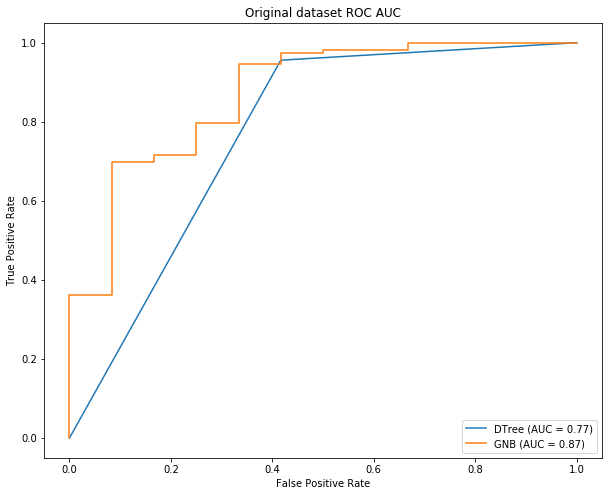

In [15]:
fig= plt.figure(figsize=(10, 8))
ax = plt.gca()
fig.add_axes(ax)
plt.title("Original dataset ROC AUC")
plot_roc_curve(best_tree_est, ori_X_test, ori_y_test, 
               name="DTree", ax=ax)
plot_roc_curve(best_gnb_est, ori_X_test, ori_y_test, 
               name="GNB", ax=ax)
plt.show()

In [16]:
# 现在测试我们自己的SMOTE的数据
stkf = StratifiedKFold(n_splits=5, random_state=666, shuffle=True)
fold = 1

best_tree_est = None
best_tree_f1 = -np.Inf
best_gnb_est = None
best_gnb_f1 = -np.Inf

my_smote_X, my_smote_X_test, \
my_smote_y, my_smote_y_test = train_test_split(new_X, new_y,
                                              random_state=666)

for train_index, vaild_index in stkf.split(my_smote_X, my_smote_y):
    X_train, y_train = my_smote_X[train_index], my_smote_y[train_index]
    X_test, y_test = my_smote_X[vaild_index], my_smote_y[vaild_index]
    
    tree = DecisionTreeClassifier(random_state=666)
    tree.fit(X_train, y_train)
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    y_pred_tree = tree.predict(X_test)
    y_pred_gnb = gnb.predict(X_test)
    
    y_f1score_tree = f1_score(y_test, y_pred_tree)
    y_f1score_gnb = f1_score(y_test, y_pred_gnb)
    
    if y_f1score_tree >  best_tree_f1:
        best_tree_f1 = y_f1score_tree
        best_tree_est = tree
    
    if y_f1score_gnb > best_gnb_f1:
        best_gnb_f1 = y_f1score_gnb
        best_gnb_est = gnb
    
    print(f"Fold {fold}:\nTree f1_score: {y_f1score_tree}\tTree Best\
     f1_score: {best_tree_f1}\nGNB f1_score: {y_f1score_gnb}\tGNB Best \
     f1_score: {best_gnb_f1}\n{40*'-'}")

Fold 1:
Tree f1_score: 0.9473684210526316	Tree Best     f1_score: 0.9473684210526316
GNB f1_score: 0.9051094890510949	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9253731343283583	Tree Best     f1_score: 0.9473684210526316
GNB f1_score: 0.8382352941176471	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9333333333333335	Tree Best     f1_score: 0.9473684210526316
GNB f1_score: 0.8985507246376812	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9333333333333335	Tree Best     f1_score: 0.9473684210526316
GNB f1_score: 0.8732394366197184	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9710144927536232	Tree Best     f1_score: 0.9710144927536232
GNB f1_score: 0.863013698630137	GNB Best      f1_score: 0.9051094890510949
--------------------------------

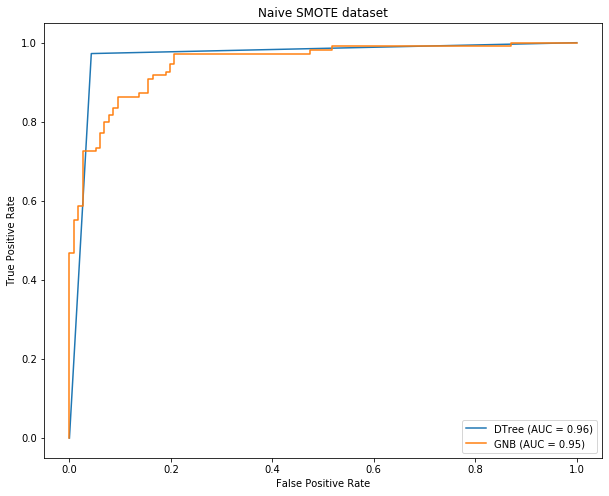

In [17]:
fig= plt.figure(figsize=(10, 8))
ax = plt.gca()
fig.add_axes(ax)
plt.title("Naive SMOTE dataset")
plot_roc_curve(best_tree_est, my_smote_X_test, my_smote_y_test, name="DTree", ax=ax)
plot_roc_curve(best_gnb_est, my_smote_X_test, my_smote_y_test, name="GNB", ax=ax)
plt.show()

In [18]:
# 测试第三方的SMOTE
stkf = StratifiedKFold(n_splits=5, random_state=666, shuffle=True)
fold = 1

best_tree_est = None
best_tree_f1 = -np.Inf
best_gnb_est = None
best_gnb_f1 = -np.Inf

third_smote_X, third_smote_X_test, \
third_smote_y, third_smote_y_test = train_test_split(X_res, y_res,
                                                    random_state=666)

for train_index, vaild_index in stkf.split(third_smote_X, third_smote_y):
    X_train, y_train = third_smote_X[train_index], third_smote_y[train_index]
    X_test, y_test = third_smote_X[vaild_index], third_smote_y[vaild_index]
    
    tree = DecisionTreeClassifier(random_state=666)
    tree.fit(X_train, y_train)
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    y_pred_tree = tree.predict(X_test)
    y_pred_gnb = gnb.predict(X_test)
    
    y_f1score_tree = f1_score(y_test, y_pred_tree)
    y_f1score_gnb = f1_score(y_test, y_pred_gnb)
    
    if y_f1score_tree >  best_tree_f1:
        best_tree_f1 = y_f1score_tree
        best_tree_est = tree
    
    if y_f1score_gnb > best_gnb_f1:
        best_gnb_f1 = y_f1score_gnb
        best_gnb_est = gnb
    
    print(f"Fold {fold}:\nTree f1_score: {y_f1score_tree}\tTree Best\
     f1_score: {best_tree_f1}\nGNB f1_score: {y_f1score_gnb}\tGNB Best \
     f1_score: {best_gnb_f1}\n{40*'-'}")

Fold 1:
Tree f1_score: 0.9384615384615386	Tree Best     f1_score: 0.9384615384615386
GNB f1_score: 0.9051094890510949	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9333333333333335	Tree Best     f1_score: 0.9384615384615386
GNB f1_score: 0.8571428571428571	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9090909090909091	Tree Best     f1_score: 0.9384615384615386
GNB f1_score: 0.8613138686131386	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9333333333333335	Tree Best     f1_score: 0.9384615384615386
GNB f1_score: 0.8827586206896552	GNB Best      f1_score: 0.9051094890510949
----------------------------------------
Fold 1:
Tree f1_score: 0.9640287769784173	Tree Best     f1_score: 0.9640287769784173
GNB f1_score: 0.8920863309352518	GNB Best      f1_score: 0.9051094890510949
-------------------------------

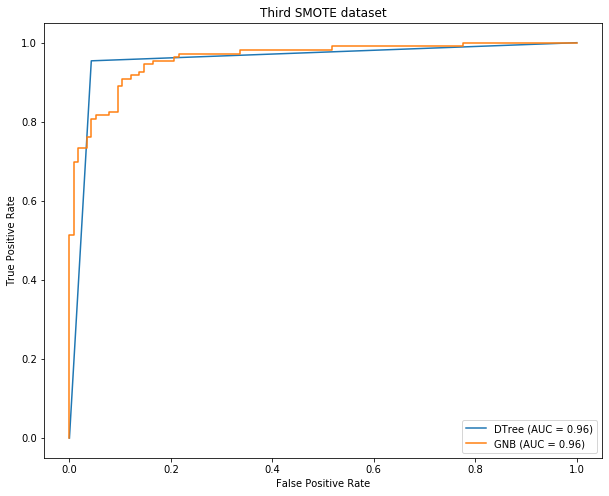

In [19]:
fig= plt.figure(figsize=(10, 8))
ax = plt.gca()
fig.add_axes(ax)
plt.title("Third SMOTE dataset")
plot_roc_curve(best_tree_est, third_smote_X_test, third_smote_y_test,
               name="DTree", ax=ax)
plot_roc_curve(best_gnb_est, third_smote_X_test, third_smote_y_test,
               name="GNB", ax=ax)
plt.show()